In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Promo & Non-Promo Classification

In [ ]:
!pip install pandas tqdm transformers sentence-transformers scikit-learn nltk datasets

In [ ]:
import pandas as pd
import re
import string
import nltk
import numpy as np
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import classification_report
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
stopwords_id = set(stopwords.words('indonesian'))

def process_text(text):
    # Lowercase
    text = text.lower()

    # Entity masking
    text = re.sub(r'http\S+|www\S+', '_url_', text)
    text = re.sub(r'@\w+', '_username_', text)
    text = re.sub(r'#\w+', '_hashtag_', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Stopwords elimination
    text = ' '.join([word for word in text.split() if word not in stopwords_id])

    return text

# Preprocess Texts
def preprocess_texts(texts):
    processed_texts = []
    for text in tqdm(texts, desc="Preprocessing Texts"):
        tokens = process_text(text)
        processed_texts.append(tokens)
    return processed_texts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load Model and Tokenizer
# first_model_path = "/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/MODEL/Promo-Non Classification/IndoBERT-UnderSampling"
# second_model_path = "/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/MODEL/Promo-Category Classification/IndoBERT"
first_model_path = "/content/drive/MyDrive/TUGAS BESAR NLP/MODEL/Promo-Non Classification/IndoBERT-UnderSampling"
second_model_path = "/content/drive/MyDrive/TUGAS BESAR NLP/MODEL/Promo-Category Classification/IndoBERT"
# third_model_path = ""

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(first_model_path)

# Load models
first_model = AutoModelForSequenceClassification.from_pretrained(first_model_path)
second_model = AutoModelForSequenceClassification.from_pretrained(second_model_path)

In [ ]:
# Define pipelines for models
first_pipeline = pipeline("text-classification", model=first_model, tokenizer=tokenizer)
second_pipeline = pipeline("text-classification", model=second_model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
def analyze_promo(test_dataset_path):
    # Load dataset
    print("\nLoading Test Dataset...")
    df_test = pd.read_csv(test_dataset_path, sep='\t')

    # Preprocess clean_tweet column
    print("\nPreprocessing Texts...")
    df_test['clean_tweet'] = preprocess_texts(df_test['full_text'].tolist())

    print(df_test.head())

    X_test = df_test['clean_tweet'].tolist()
    y_test_promo = df_test['label_promo'].tolist()
    y_test_category = df_test['label_category'].tolist()

    # First Model Predictions (Promo/Non-Promo)
    print("\nRunning First Model (Promo/Non-Promo Classification)...")
    first_preds = []
    promo_indices = []
    promo_texts = []

    for idx, text in enumerate(tqdm(X_test, desc="Processing First Model")):
        result = first_pipeline(text)[0]
        label = int(result['label'].split('_')[-1])
        first_preds.append(label)
        if label == 1:
            promo_indices.append(idx)
            promo_texts.append(text)

    df_test['first_model_pred'] = first_preds

    # Second Model (Promo Category) and Third Model (NER)
    print("\nRunning Second and Third Models...")
    second_preds = [-1] * len(df_test)
    # third_preds = []

    if promo_texts:
        for idx, text in enumerate(tqdm(promo_texts, desc="Processing Second Model")):
            # Promo Category Classification
            second_result = second_pipeline(text)[0]
            second_preds[promo_indices[idx]] = int(second_result['label'].split('_')[-1])

    df_test['second_model_pred'] = second_preds

     # Save Predictions to TSV Files
    print("\nSaving Predictions to TSV Files...")
    # first_model_output_path = "/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/RESULT/first_model_results.tsv"
    # second_model_output_path = "/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/RESULT/second_model_results.tsv"
    first_model_output_path = "/content/drive/MyDrive/TUGAS BESAR NLP/RESULT/first_model_results.tsv"
    second_model_output_path = "/content/drive/MyDrive/TUGAS BESAR NLP/RESULT/second_model_results.tsv"

    df_first = df_test[['full_text', 'label_promo', 'first_model_pred']]
    df_first.to_csv(first_model_output_path, sep='\t', index=False)
    print(f"First Model Results Saved to {first_model_output_path}")

    df_second = df_test.loc[df_test['first_model_pred'] == 1, ['full_text', 'label_category', 'second_model_pred']]
    df_second.to_csv(second_model_output_path, sep='\t', index=False)
    print(f"Second Model Results Saved to {second_model_output_path}")

    # Classification Report for First Model
    print("\nClassification Report for First Model (Promo/Non-Promo):")
    print(classification_report(y_test_promo, first_preds, target_names=["Non-Promo", "Promo"]))

    # Classification Report for Second Model
    if promo_texts:
        print("\nClassification Report for Second Model (Promo Categories):")
        print(classification_report(y_test_category, second_preds))
    else:
        print("\nNo 'Promo' texts classified. Skipping Second Model Report.")

In [ ]:
# test_dataset_path = "/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/COMBINED/new_test_dataset.tsv"
test_dataset_path = "/content/drive/MyDrive/TUGAS BESAR NLP/COMBINED/new_test_dataset.tsv"
analyze_promo(test_dataset_path)


Loading Test Dataset...

Preprocessing Texts...


Preprocessing Texts: 100%|██████████| 90/90 [00:00<00:00, 17889.55it/s]


                                           full_text  label_promo  \
0  Pesan paket wisata ke Pulau Komodo dengan harg...            1   
1  Yg mau coba twc luxcrime coba cek dishopee dpe...            1   
2  Streaming musik favoritmu di Spotify Premium! ...            1   
3  30 menit ngescroll gofood, grabfood, shopeefoo...            0   
4  Dapatkan promo menginap di hotel mewah di Lomb...            1   

   label_category                                        clean_tweet  
0               4  pesan paket wisata pulau komodo harga rp200000...  
1               6  yg coba twc luxcrime coba cek dishopee dpet ha...  
2               2  streaming musik favoritmu spotify premium prom...  
3              -1  30 menit ngescroll gofood grabfood shopeefood ...  
4               4  dapatkan promo menginap hotel mewah lombok har...  

Running First Model (Promo/Non-Promo Classification)...


Processing First Model: 100%|██████████| 90/90 [00:27<00:00,  3.33it/s]



Running Second and Third Models...


Processing Second Model: 100%|██████████| 82/82 [00:24<00:00,  3.33it/s]


Saving Predictions to TSV Files...
First Model Results Saved to /content/drive/MyDrive/TUGAS BESAR NLP/RESULT/first_model_results.tsv
Second Model Results Saved to /content/drive/MyDrive/TUGAS BESAR NLP/RESULT/second_model_results.tsv

Classification Report for First Model (Promo/Non-Promo):
              precision    recall  f1-score   support

   Non-Promo       0.88      1.00      0.93         7
       Promo       1.00      0.99      0.99        83

    accuracy                           0.99        90
   macro avg       0.94      0.99      0.96        90
weighted avg       0.99      0.99      0.99        90


Classification Report for Second Model (Promo Categories):
              precision    recall  f1-score   support

          -1       0.88      1.00      0.93         7
           0       0.89      1.00      0.94         8
           1       1.00      0.93      0.96        14
           2       0.79      0.92      0.85        12
           3       0.88      1.00      0.94     

# Clustering for Promo Data

In [ ]:
#load data
# data_path = "/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/COMBINED/test_dataset.tsv"
data_path = "/content/drive/MyDrive/TUGAS BESAR NLP/COMBINED/test_dataset.tsv"
df = pd.read_csv(data_path, sep='\t')
df.head()

,full_text,label_promo,label_category
0,@sbyfess klo mau murah naik bus damri 30rb cmi...,0,-1
1,Pesan paket wisata ke Pulau Komodo dengan harg...,1,4
2,Itu harga yg keliatan murah krna ada kupon dis...,0,-1
3,Bayar QRIS pakai SPayLater emang bisa? Bisa do...,1,6
4,Yg mau coba twc luxcrime coba cek dishopee dpe...,1,6


In [ ]:
df = df[df['label_promo'] == 1].copy()
df = df.reset_index(drop=True)
df.head()

,full_text,label_promo,label_category
0,Pesan paket wisata ke Pulau Komodo dengan harg...,1,4
1,Bayar QRIS pakai SPayLater emang bisa? Bisa do...,1,6
2,Yg mau coba twc luxcrime coba cek dishopee dpe...,1,6
3,Streaming musik favoritmu di Spotify Premium! ...,1,2
4,Dapatkan promo menginap di hotel mewah di Lomb...,1,4


In [ ]:
from sentence_transformers import SentenceTransformer, util
# model_path =  "/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/MODEL/Promo-Clustering/"
model_path =  "/content/drive/MyDrive/TUGAS BESAR NLP/MODEL/Promo-Clustering/"
model = SentenceTransformer(model_path)

## Finding optimal K

In [ ]:
# see if the PCA could lead into a better clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

def pca_plot(sentences, model = model):
  # Reduce dimensions using PCA
  pca = PCA(n_components=15)
  new_embeddings = model.encode(sentences, convert_to_tensor=True)
  pca_embeddings = pca.fit_transform(new_embeddings.cpu().numpy())

  # Find the right elbow
  sse = []
  for k in tqdm(range(3, 20), desc="Measure optimal k"):
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans.fit(pca_embeddings)
      sse.append(kmeans.inertia_)

  # Plot Elbow Curve
  plt.figure(figsize=(12, 6))
  plt.plot(range(3, 20), sse, marker='o')
  plt.xticks(range(3, 20))
  plt.title('Elbow Curve with PCA', fontsize=16)
  plt.xlabel('Number of Clusters (k)', fontsize=14)
  plt.ylabel('Sum of Squared Errors (SSE)', fontsize=14)
  plt.grid()
  plt.show()


Measure optimal k: 100%|██████████| 17/17 [00:00<00:00, 104.82it/s]


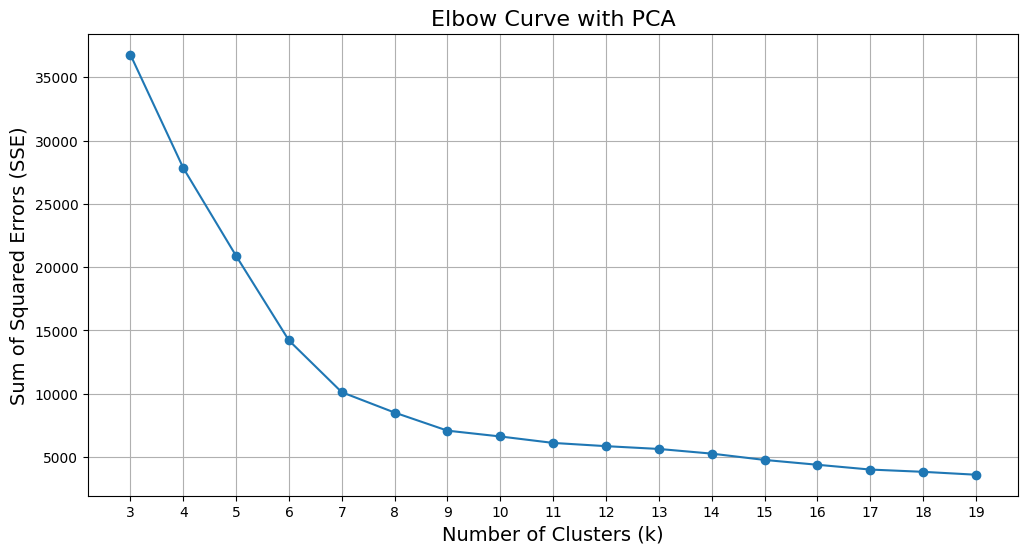

In [ ]:
pca_plot(np.array(df['full_text']))

Dari grafik di atas, bisa dilihat pivot elbow di k = 7 (sesuai dengan jumlah label dataset)

In [ ]:
from sklearn.metrics import silhouette_score

def silhouette_plot(sentences, model=model):
    # Reduce dimensions using PCA
    pca = PCA(n_components=15)
    new_embeddings = model.encode(sentences, convert_to_tensor=True)
    pca_embeddings = pca.fit_transform(new_embeddings.cpu().numpy())

    # Compute silhouette scores for different numbers of clusters
    silhouette_scores = []
    for k in tqdm(range(3, 15), desc="Measure silhouette scores"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(pca_embeddings)
        score = silhouette_score(pca_embeddings, cluster_labels)
        silhouette_scores.append(score)

    # Plot Silhouette Scores
    plt.figure(figsize=(12, 6))
    plt.plot(range(3, 15), silhouette_scores, marker='o', color='orange')
    plt.xticks(range(3, 15))
    plt.title('Silhouette Score Curve', fontsize=16)
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=14)
    plt.grid()
    plt.show()

Measure silhouette scores: 100%|██████████| 12/12 [00:00<00:00, 79.96it/s]


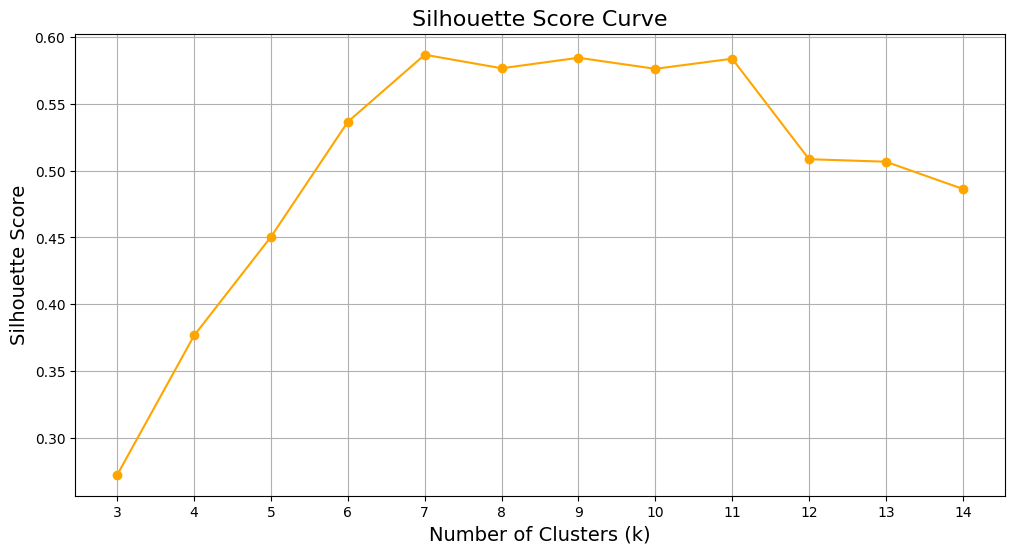

In [ ]:
silhouette_plot(np.array(df['full_text']))

Dari silhoutte analisis, dapat dipilih k = 9 sebagai k optimum untuk clustering

## Clustering Analysis

In [ ]:
_cluster_labels = {
    0 : 'food',
    1  : 'beauty',
    2 : 'entertaiment',
    3 : 'fashion',
    4 : 'technology',
    5 : 'travel & leissure',
    6 : 'others'
}

def the_clustering(df = df, _cluster_labels = _cluster_labels, k = 7):
  #Embeddings
  _df = df.copy()
  sentences = _df['full_text']
  embeddings = model.encode(sentences, convert_to_tensor=True)
  # PCA
  pca = PCA(n_components=15)
  pca_embeddings = pca.fit_transform(embeddings.cpu().numpy())

  #clustering
  kmeans = KMeans(n_clusters=k, random_state=42)
  clusters = kmeans.fit_predict(pca_embeddings)

  # get array of cluster
  cluster_array = kmeans.labels_
  # convert each cluster, for example: 0 -> 'A', 1 -> 'B', etc.
  cluster_array = np.array([chr(65 + i) for i in cluster_array])

  _df['label_text'] = [_cluster_labels[k] for k in _df['label_category']]
  _df['clustering_results'] = cluster_array
  print("Done Performing Clustering....")

  #for every unique cluster, plot the distribution of labels
  for cluster in _df['clustering_results'].unique():
      sns.countplot(x='label_text', data=_df[_df['clustering_results'] == cluster])
      plt.title(f'Distribution of labels for cluster {cluster}')
      plt.show()

Done Performing Clustering....


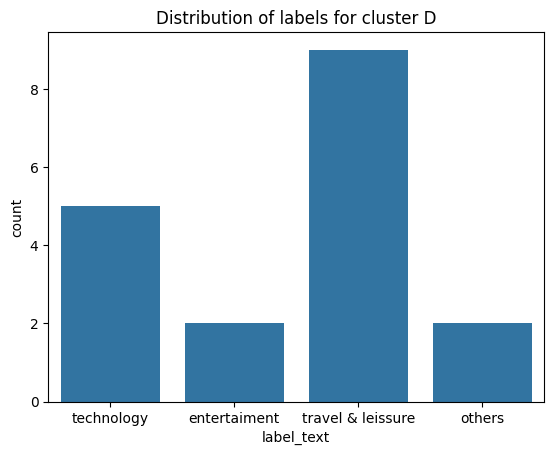

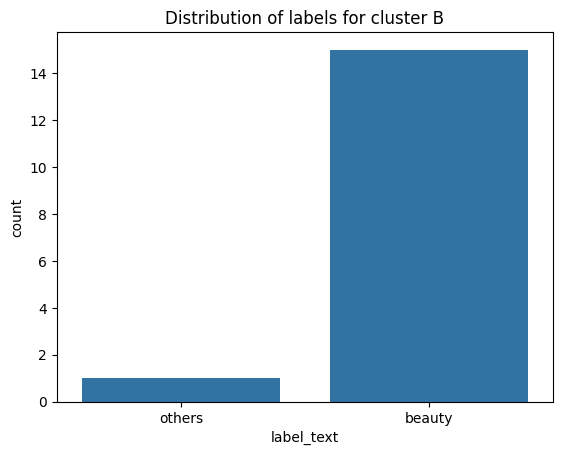

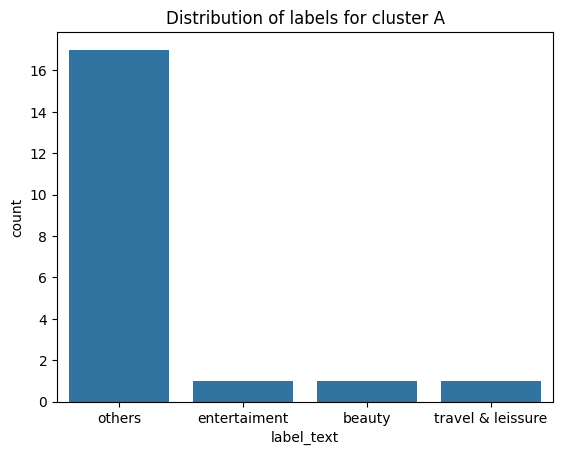

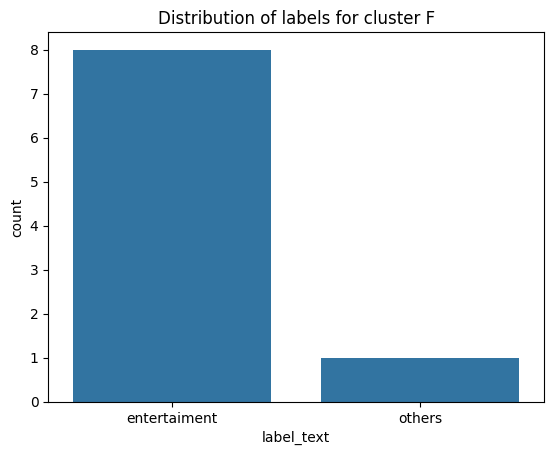

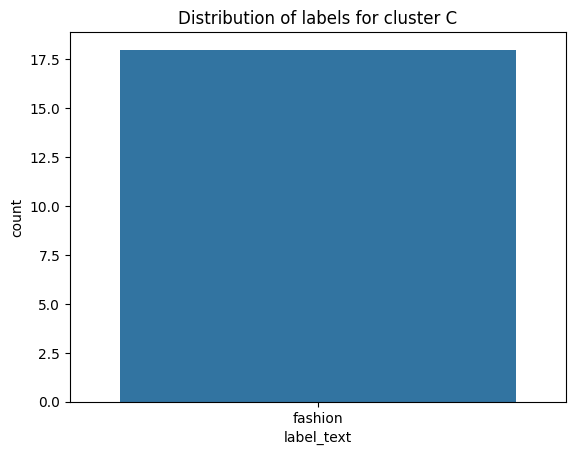

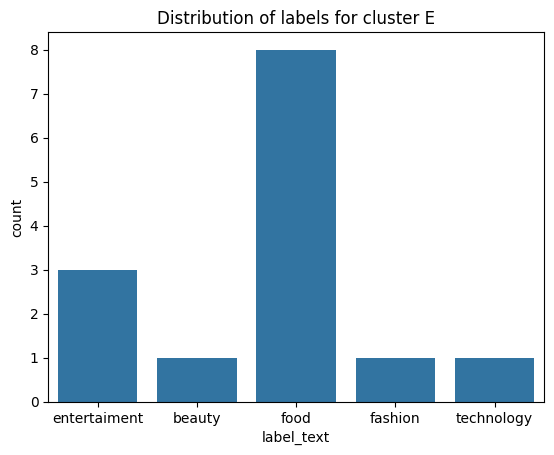

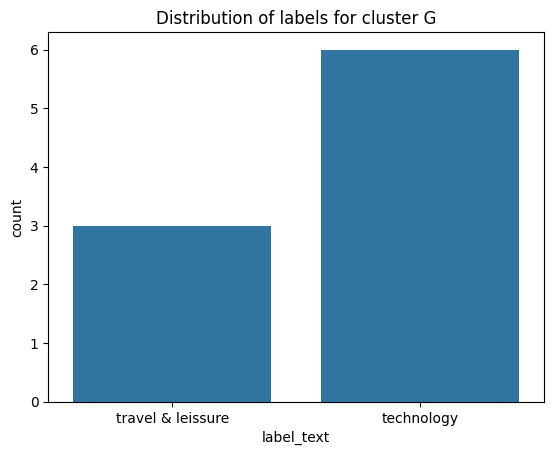

In [ ]:
the_clustering()

Done Performing Clustering....


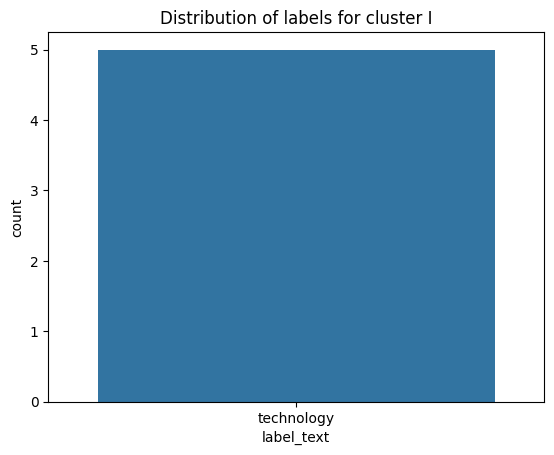

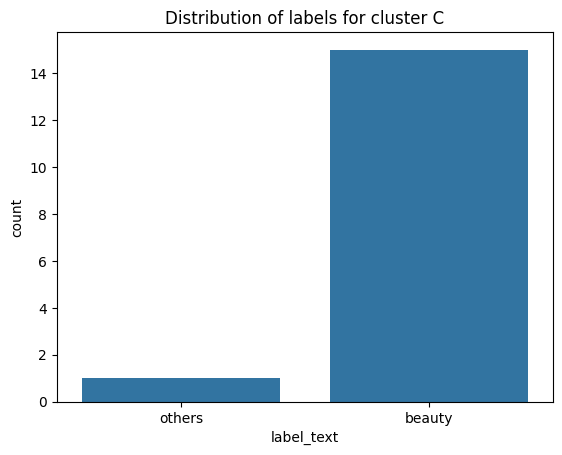

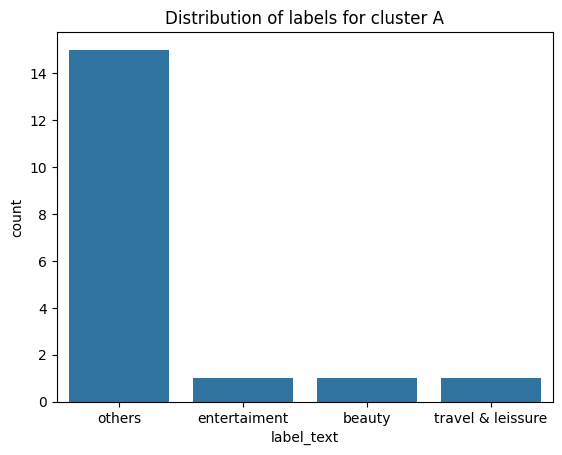

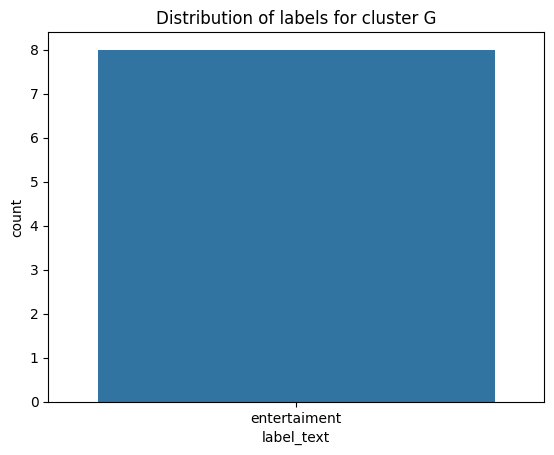

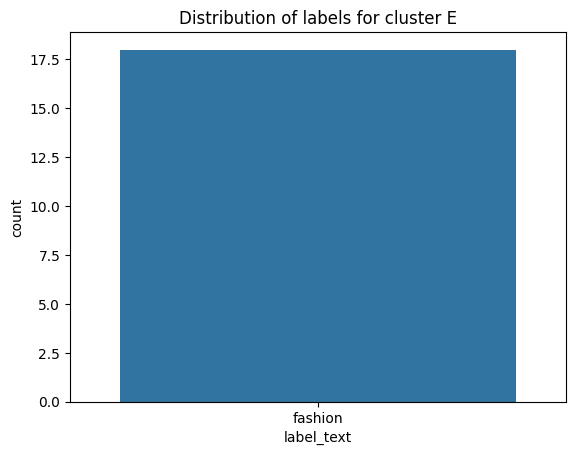

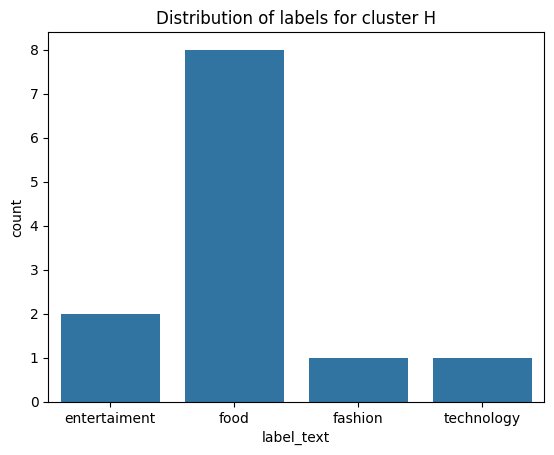

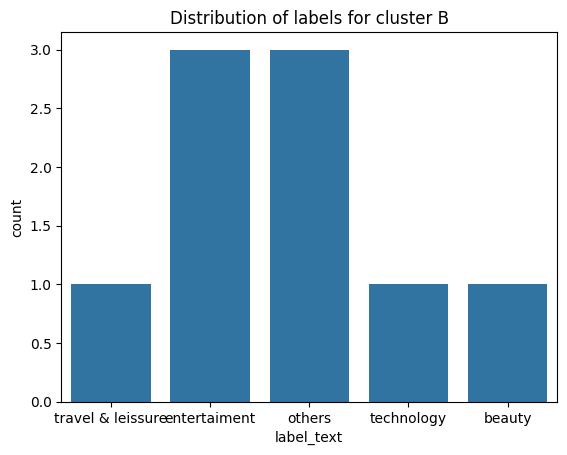

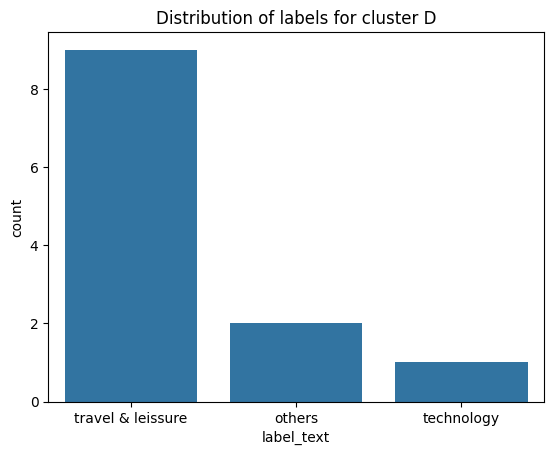

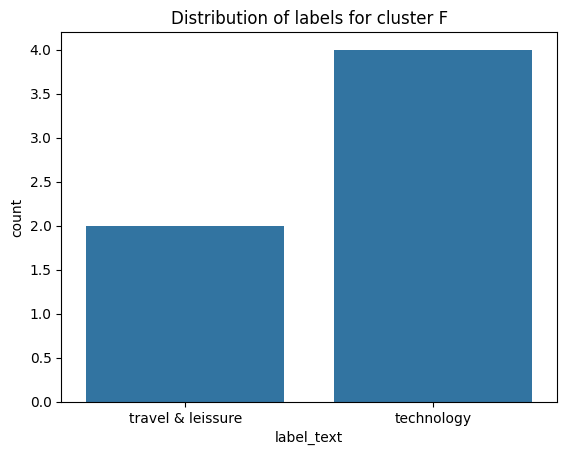

In [ ]:
the_clustering(k=9)

In [ ]:
def cluster_plot(df = df, k =7):
  #Embeddings
  _df = df.copy()
  sentences = _df['full_text']
  embeddings = model.encode(sentences, convert_to_tensor=True)
  # PCA
  pca = PCA(n_components=2)
  pca_embeddings = pca.fit_transform(embeddings.cpu().numpy())
  #clustering
  kmeans = KMeans(n_clusters=k, random_state=42)
  clusters = kmeans.fit_predict(pca_embeddings)

  plt.figure(figsize=(10, 7))
  plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
  plt.title('2D Visualization of Sentence Embeddings using PCA', fontsize=16)
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.colorbar()  # Show color bar to represent clusters
  plt.show()

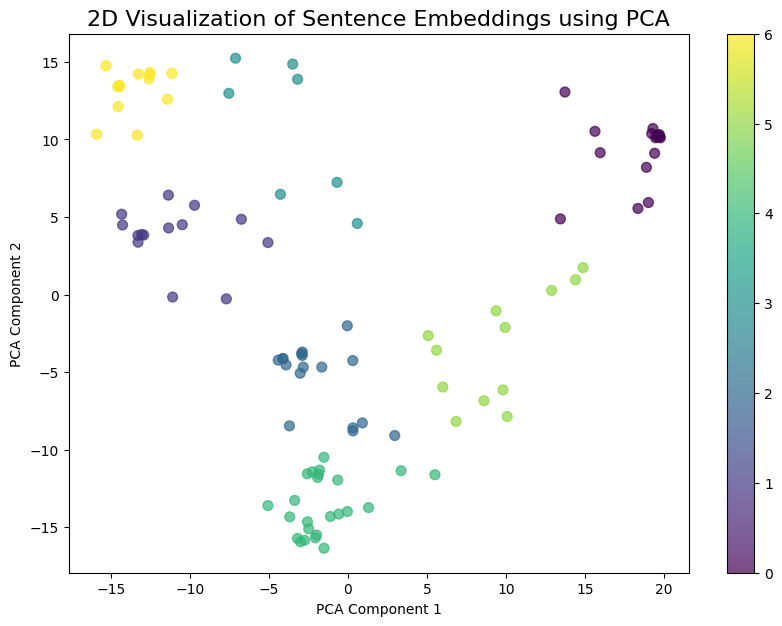

In [ ]:
cluster_plot()

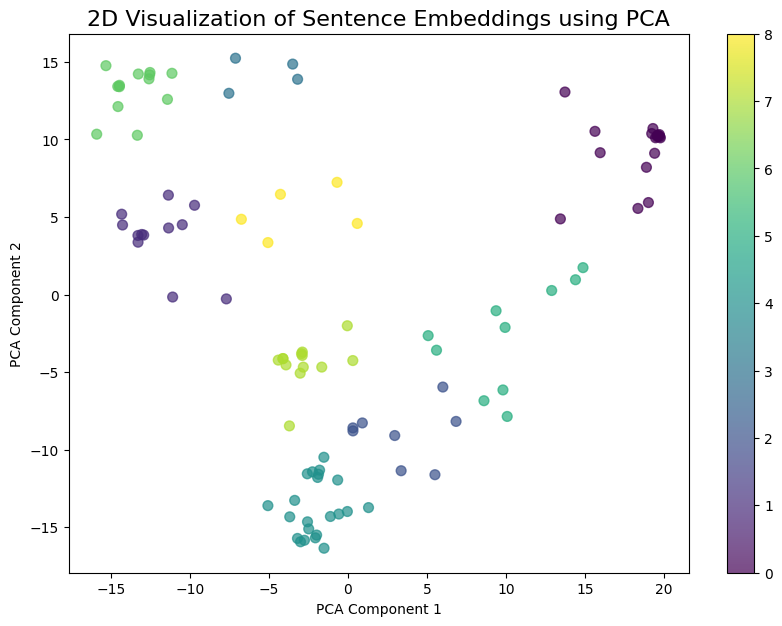

In [ ]:
cluster_plot(k=9)

# Name Entity Recognition for Promo Data

In [ ]:
#LOAD MODEL
import spacy

# spacy_model_path = "/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/MODEL/Promo-NER/"
spacy_model_path = "/content/drive/MyDrive/TUGAS BESAR NLP/MODEL/Promo-NER/"
loaded_nlp = spacy.load(spacy_model_path)
print("Model berhasil dimuat kembali!")


Model berhasil dimuat kembali!


In [ ]:
# LOAD DATASET
import json

# test_data_path = '/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/COMBINED/test_dataset_ner.json'
test_data_path = '/content/drive/MyDrive/TUGAS BESAR NLP/COMBINED/test_dataset_ner.json'
# read json
with open(test_data_path) as f:
  test_data = json.load(f)


In [ ]:
from collections import Counter

def evaluate_ner(actual_entities, predicted_entities):
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    # Iterasi untuk mencocokkan actual dan predicted
    for actual_text, actual_label in actual_entities:
        match_found = False
        for predicted_text, predicted_label in predicted_entities:
            if actual_label == predicted_label:  # Cek label cocok
                # Cek subset match
                if predicted_text in actual_text or actual_text in predicted_text:
                    tp += 1
                    match_found = True
                    break
        if not match_found:
            fn += 1  # Tidak ditemukan pasangan yang cocok untuk entitas aktual

    # Hitung false positives
    for predicted_text, predicted_label in predicted_entities:
        match_found = False
        for actual_text, actual_label in actual_entities:
            if predicted_label == actual_label:  # Cek label cocok
                # Cek subset match
                if predicted_text in actual_text or actual_text in predicted_text:
                    match_found = True
                    break
        if not match_found:
            fp += 1  # Tidak ditemukan pasangan yang cocok untuk entitas prediksi

    # Total Entities
    total_entities = len(actual_entities) + len(predicted_entities) - tp

    # Hitung metrik
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = tp / total_entities if total_entities > 0 else 0

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

# Evaluasi data test
overall_results = Counter()  # Untuk menghitung rata-rata
for text, annotations in test_data:
    print("Text: ", text)
    # Parse annotations to extract actual entities
    actual_entities = [(text[ent[0]:ent[1]], ent[2]) for ent in annotations["entities"]]
    print("Actual Entities: ", actual_entities)

    # Predicted annotations
    doc = loaded_nlp(text)  # Predict using the trained model
    predicted_entities = [(ent.text, ent.label_) for ent in doc.ents]

    print("Predicted Entities: ", predicted_entities)
    print()

    # Hitung metrik untuk teks ini
    results = evaluate_ner(actual_entities, predicted_entities)

    # Update hasil keseluruhan
    overall_results.update(results)

# Hitung rata-rata untuk keseluruhan data test
average_precision = overall_results["precision"] / len(test_data)
average_recall = overall_results["recall"] / len(test_data)
average_f1 = overall_results["f1"] / len(test_data)

print("Overall Performance:")
print(f"Precision: {average_precision:.2f}, Recall: {average_recall:.2f}, F1: {average_f1:.2f}")

Text:  WTS PROMO NONTON DI BIOSKOP CGV FREE POPCORN Order via wa: https://t.co/SYP4OoXsiF ️ Diskon Tiket Mins. Harga 1 tiket* 35k. Jadinya 30k/tix FREE ADMIN &amp; FREE FEE *Harga 1 tiket tergantung lokasi FREE POPCORN min. Pembelian 2 Tiket Tg wts murah voucher diskon kode https://t.co/GKNwxSZFwg
Actual Entities:  [('BIOSKOP', 'LOCATION'), ('CGV', 'PLATFORM'), ('FREE POPCORN', 'PROMO'), ('Harga 1 tiket* 35k. Jadinya 30k/tix', 'PROMO'), ('FREE ADMIN', 'PROMO'), ('FREE FEE', 'PROMO'), ('FREE POPCORN', 'PROMO'), ('voucher diskon', 'PRODUCT')]
Predicted Entities:  [('CGV', 'PLATFORM'), ('FREE POPCORN', 'PROMO'), ('Harga 1 tiket* 35k. Jadinya 30k/tix', 'PROMO'), ('FREE ADMIN', 'PROMO'), ('FREE FEE', 'PROMO'), ('FREE POPCORN', 'PROMO'), ('voucher diskon', 'PRODUCT')]

Text:  DISKON MAKANAN &amp; MINUMAN PROMO 10.10 A thread https://t.co/zwAyoQQorY
Actual Entities:  [('PROMO 10.10', 'EVENT')]
Predicted Entities:  [('DISKON MAKANAN &amp;', 'PROMO'), ('MINUMAN', 'PRODUCT'), ('PROMO 10.10', 'EV



## Kesimpulan

### 1. Data
- **Sumber Data**: Tweet yang dikumpulkan melalui *scraping*
- **Penyimpanan**: di Google Drive dan GitHub

### 2. Klasifikasi Promo/Non-Promo
- **Model**: IndoBERT
- **Proses Pelatihan**: 4 epoch
- **Performa Memuaskan**:
  - Akurasi: 99%
  - F1-Score: 96%
  - Recall: 99%
  - Presisi: 94%

### 3. Klasifikasi Kategori Promosi
- **Model**: IndoBERT
- **Proses Pelatihan**: 5 epoch
- **Performa yang =Cukup Memuaskan**:
  - Akurasi: 79%
  - F1-Score: 77%
  - Recall: 76%
  - Presisi: 80%

### 4. Clustering Promosi
- **Teknik**: *Sentence Transformers*
- **Model**: Indo Sentence Bert Base
- **Fine-Tuning**: 2 epoch
- **Metode Evaluasi**:
  - Sum of Squared Error (SSE)
  - *Silhouette Score*
- **Temuan Kunci**:
  - Jumlah klaster optimal: 7
  - Klasterisasi berhasil memisahkan data dengan baik
  - Setiap klaster memiliki label dominan yang sesuai dengan *ground truth*

### 5. Named Entity Recognition (NER) untuk Promosi
- **Capaian**: Berhasil mengidentifikasi entitas dalam tweet promosi, namun masih ada Name Entity yang belum terekognisi dengan tepat
- **Model**:  Spacy CRF (Conditional Random Fields)
- **Tantangan**: Beberapa entitas masih sulit dikenali
- **Metrik Performa**:
  - Presisi: 0.74
  - Recall: 0.61
  - F1-Score: 0.64
